In [1]:
"""
    source: https://github.com/riiswa/kanrl
"""
import os
import time
import random

import gymnasium as gym
import torch
import torch.nn as nn
from hydra.core.hydra_config import HydraConfig
from kan import KAN
from torch.utils.tensorboard import SummaryWriter
import numpy as np

from buffer import ReplayBuffer
import hydra
from omegaconf import DictConfig
from tqdm import tqdm

import matplotlib.pyplot as plt

class config:
    def __init__(self):
        self.env_id= "CartPole-v1"
        self.batch_size= 60
        self.n_episodes= 500
        self.warm_up_episodes= 50
        self.gamma= 0.99
        self.train_steps= 10
        self.target_update_freq= 10
        self.learning_rate= 0.0005
        self.replay_buffer_capacity= 10000
        self.width= 8
        self.grid= 5
        self.method= "KAN"
        self.seed= 0
        self.chance = 0

def kan_train(
    net,
    target,
    data,
    optimizer,
    gamma=0.99,
    lamb=0.0,
    lamb_l1=1.0,
    lamb_entropy=2.0,
    lamb_coef=0.0,
    lamb_coefdiff=0.0,
    small_mag_threshold=1e-16,
    small_reg_factor=1.0,
):
    def reg(acts_scale):
        def nonlinear(x, th=small_mag_threshold, factor=small_reg_factor):
            return (x < th) * x * factor + (x > th) * (x + (factor - 1) * th)

        reg_ = 0.0
        for i in range(len(acts_scale)):
            vec = acts_scale[i].reshape(
                -1,
            )

            p = vec / torch.sum(vec)
            l1 = torch.sum(nonlinear(vec))
            entropy = -torch.sum(p * torch.log2(p + 1e-4))
            reg_ += lamb_l1 * l1 + lamb_entropy * entropy  # both l1 and entropy

        # regularize coefficient to encourage spline to be zero
        for i in range(len(net.act_fun)):
            coeff_l1 = torch.sum(torch.mean(torch.abs(net.act_fun[i].coef), dim=1))
            coeff_diff_l1 = torch.sum(
                torch.mean(torch.abs(torch.diff(net.act_fun[i].coef)), dim=1)
            )
            reg_ += lamb_coef * coeff_l1 + lamb_coefdiff * coeff_diff_l1

        return reg_

    observations, actions, next_observations, rewards, terminations = data

    with torch.no_grad():
        next_q_values = net(next_observations)
        next_actions = next_q_values.argmax(dim=1)
        next_q_values_target = target(next_observations)
        target_max = next_q_values_target[range(len(next_q_values)), next_actions]
        td_target = rewards.flatten() + gamma * target_max * (
            1 - terminations.flatten()
        )

    old_val = net(observations).gather(1, actions).squeeze()
    loss = nn.functional.mse_loss(td_target, old_val)
    reg_ = reg(net.acts_scale)
    loss = loss + lamb * reg_
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()


def mlp_train(
    net,
    target,
    data,
    optimizer,
    gamma=0.99,
):
    observations, actions, next_observations, rewards, terminations = data

    with torch.no_grad():
        next_q_values = net(next_observations)
        next_actions = next_q_values.argmax(dim=1)
        next_q_values_target = target(next_observations)
        target_max = next_q_values_target[range(len(next_q_values)), next_actions]
        td_target = rewards.flatten() + gamma * target_max * (
            1 - terminations.flatten()
        )

    old_val = net(observations).gather(1, actions).squeeze()
    loss = nn.functional.mse_loss(td_target, old_val)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()


def set_all_seeds(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms(True)


# @hydra.main(config_path=".", config_name="config", version_base=None)
def main(config: config, width, type, k = 3):
    set_all_seeds(config.seed)
    config.method = type
    # config.width = width
    env = gym.make(config.env_id)
    if config.method == "KAN":
        q_network = KAN(
            width=[env.observation_space.shape[0], config.width, 2],
            grid=config.grid,
            k=k,
            # bias_trainable=False,
            # sp_trainable=False,
            # sb_trainable=False,
        )
        target_network = KAN(
            width=[env.observation_space.shape[0], config.width, 2],
            grid=config.grid,
            k=k,
            # bias_trainable=False,
            # sp_trainable=False,
            # sb_trainable=False,
        )
        train = kan_train
    elif config.method == "MLP":
        q_network = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], config.width),
            nn.ReLU(),
            nn.Linear(config.width, config.width),
            nn.ReLU(),
            nn.Linear(config.width, env.action_space.n),
        )
        target_network = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], config.width),
            nn.ReLU(),
            nn.Linear(config.width, config.width),
            nn.ReLU(),
            nn.Linear(config.width, env.action_space.n),
        )
        train = mlp_train
    else:
        raise Exception(
            f"Method {config.method} don't exist, choose between MLP and KAN."
        )

    target_network.load_state_dict(q_network.state_dict())

    run_name = f"{config.method}_{config.env_id}_{config.seed}_{int(time.time())}"

    writer = SummaryWriter(f"runs/{run_name}")

    os.makedirs("results", exist_ok=True)
    with open(f"results/{run_name}.csv", "w") as f:
        f.write("episode,length\n")

    optimizer = torch.optim.Adam(q_network.parameters(), config.learning_rate)
    buffer = ReplayBuffer(config.replay_buffer_capacity, env.observation_space.shape[0])

    writer.add_text(
        "hyperparameters",
        "|param|value|\n|-|-|\n%s"
        % ("\n".join([f"|{key}|{value}|" for key, value in vars(config).items()])),
    )

    # pbar_position = 0 if HydraConfig.get().mode == HydraConfig.get().mode.RUN else HydraConfig.get().job.num
    loss_per_episode = []
    for episode in tqdm(range(config.n_episodes), desc=f"{run_name}"): # , position=pbar_position):
        temp_loss = []
        observation, info = env.reset()
        observation = torch.from_numpy(observation)
        finished = False
        episode_length = 0
        while not finished:
            if episode < config.warm_up_episodes:
                action = env.action_space.sample()
            else:
                action = (
                    q_network(observation.unsqueeze(0))
                    .argmax(axis=-1)
                    .squeeze()
                    .item()
                )
            next_observation, reward, terminated, truncated, info = env.step(action)
            if config.env_id == "CartPole-v1":
                reward = -1 if terminated else 0
            next_observation = torch.from_numpy(next_observation)

            buffer.add(observation, action, next_observation, reward, terminated)

            observation = next_observation
            finished = terminated or truncated
            episode_length += 1
        with open(f"results/{run_name}.csv", "a") as f:
            f.write(f"{episode},{episode_length}\n")
        temp = []
        if len(buffer) >= config.batch_size:
            for _ in range(config.train_steps):
                loss = train(
                    q_network,
                    target_network,
                    buffer.sample(config.batch_size),
                    optimizer,
                    config.gamma,
                )
                temp.append(loss)
            writer.add_scalar("episode_length", episode_length, episode)
            writer.add_scalar("loss", loss, episode)
            if (
                episode % 25 == 0
                and config.method == "KAN"
                and episode < int(config.n_episodes * (1 / 2))
            ):
                q_network.update_grid_from_samples(buffer.observations[: len(buffer)])
                target_network.update_grid_from_samples(
                    buffer.observations[: len(buffer)]
                )

            if episode % config.target_update_freq == 0:
                target_network.load_state_dict(q_network.state_dict())
        loss_per_episode.append(np.mean(temp))
    return loss_per_episode, q_network





In [2]:
config = config()

different_widths = [i for i in range(2, 6)]
loss_mlp = main(config, 8, type='MLP', k = 3)
x_mlp = [i for i in range(1, len(loss_mlp)+1)]

loss, model = main(config, 8, type='KAN', k = 3)
x = [i for i in range(1, len(loss)+1)]

MLP_CartPole-v1_0_1725296549:   0%|                     | 0/500 [00:00<?, ?it/s]/opt/homebrew/anaconda3/envs/Thesis/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/anaconda3/envs/Thesis/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
MLP_CartPole-v1_0_1725296549: 100%|███████████| 500/500 [00:05<00:00, 99.47it/s]


checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0


KAN_CartPole-v1_0_1725296555:  10%|█▏          | 49/500 [00:04<00:42, 10.54it/s]/opt/homebrew/anaconda3/envs/Thesis/lib/python3.10/site-packages/kan/MultKAN.py:798: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_e2rjusv8ek/croot/pytorch-select_1717607459930/work/aten/src/ATen/native/ReduceOps.cpp:1807.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
/opt/homebrew/anaconda3/envs/Thesis/lib/python3.10/site-packages/kan/MultKAN.py:808: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_e2rjusv8ek/croot/pytorch-select_1717607459930/work/aten/src/ATen/native/ReduceOps.cpp:1807.)
  input_range = torch.std(preacts, 

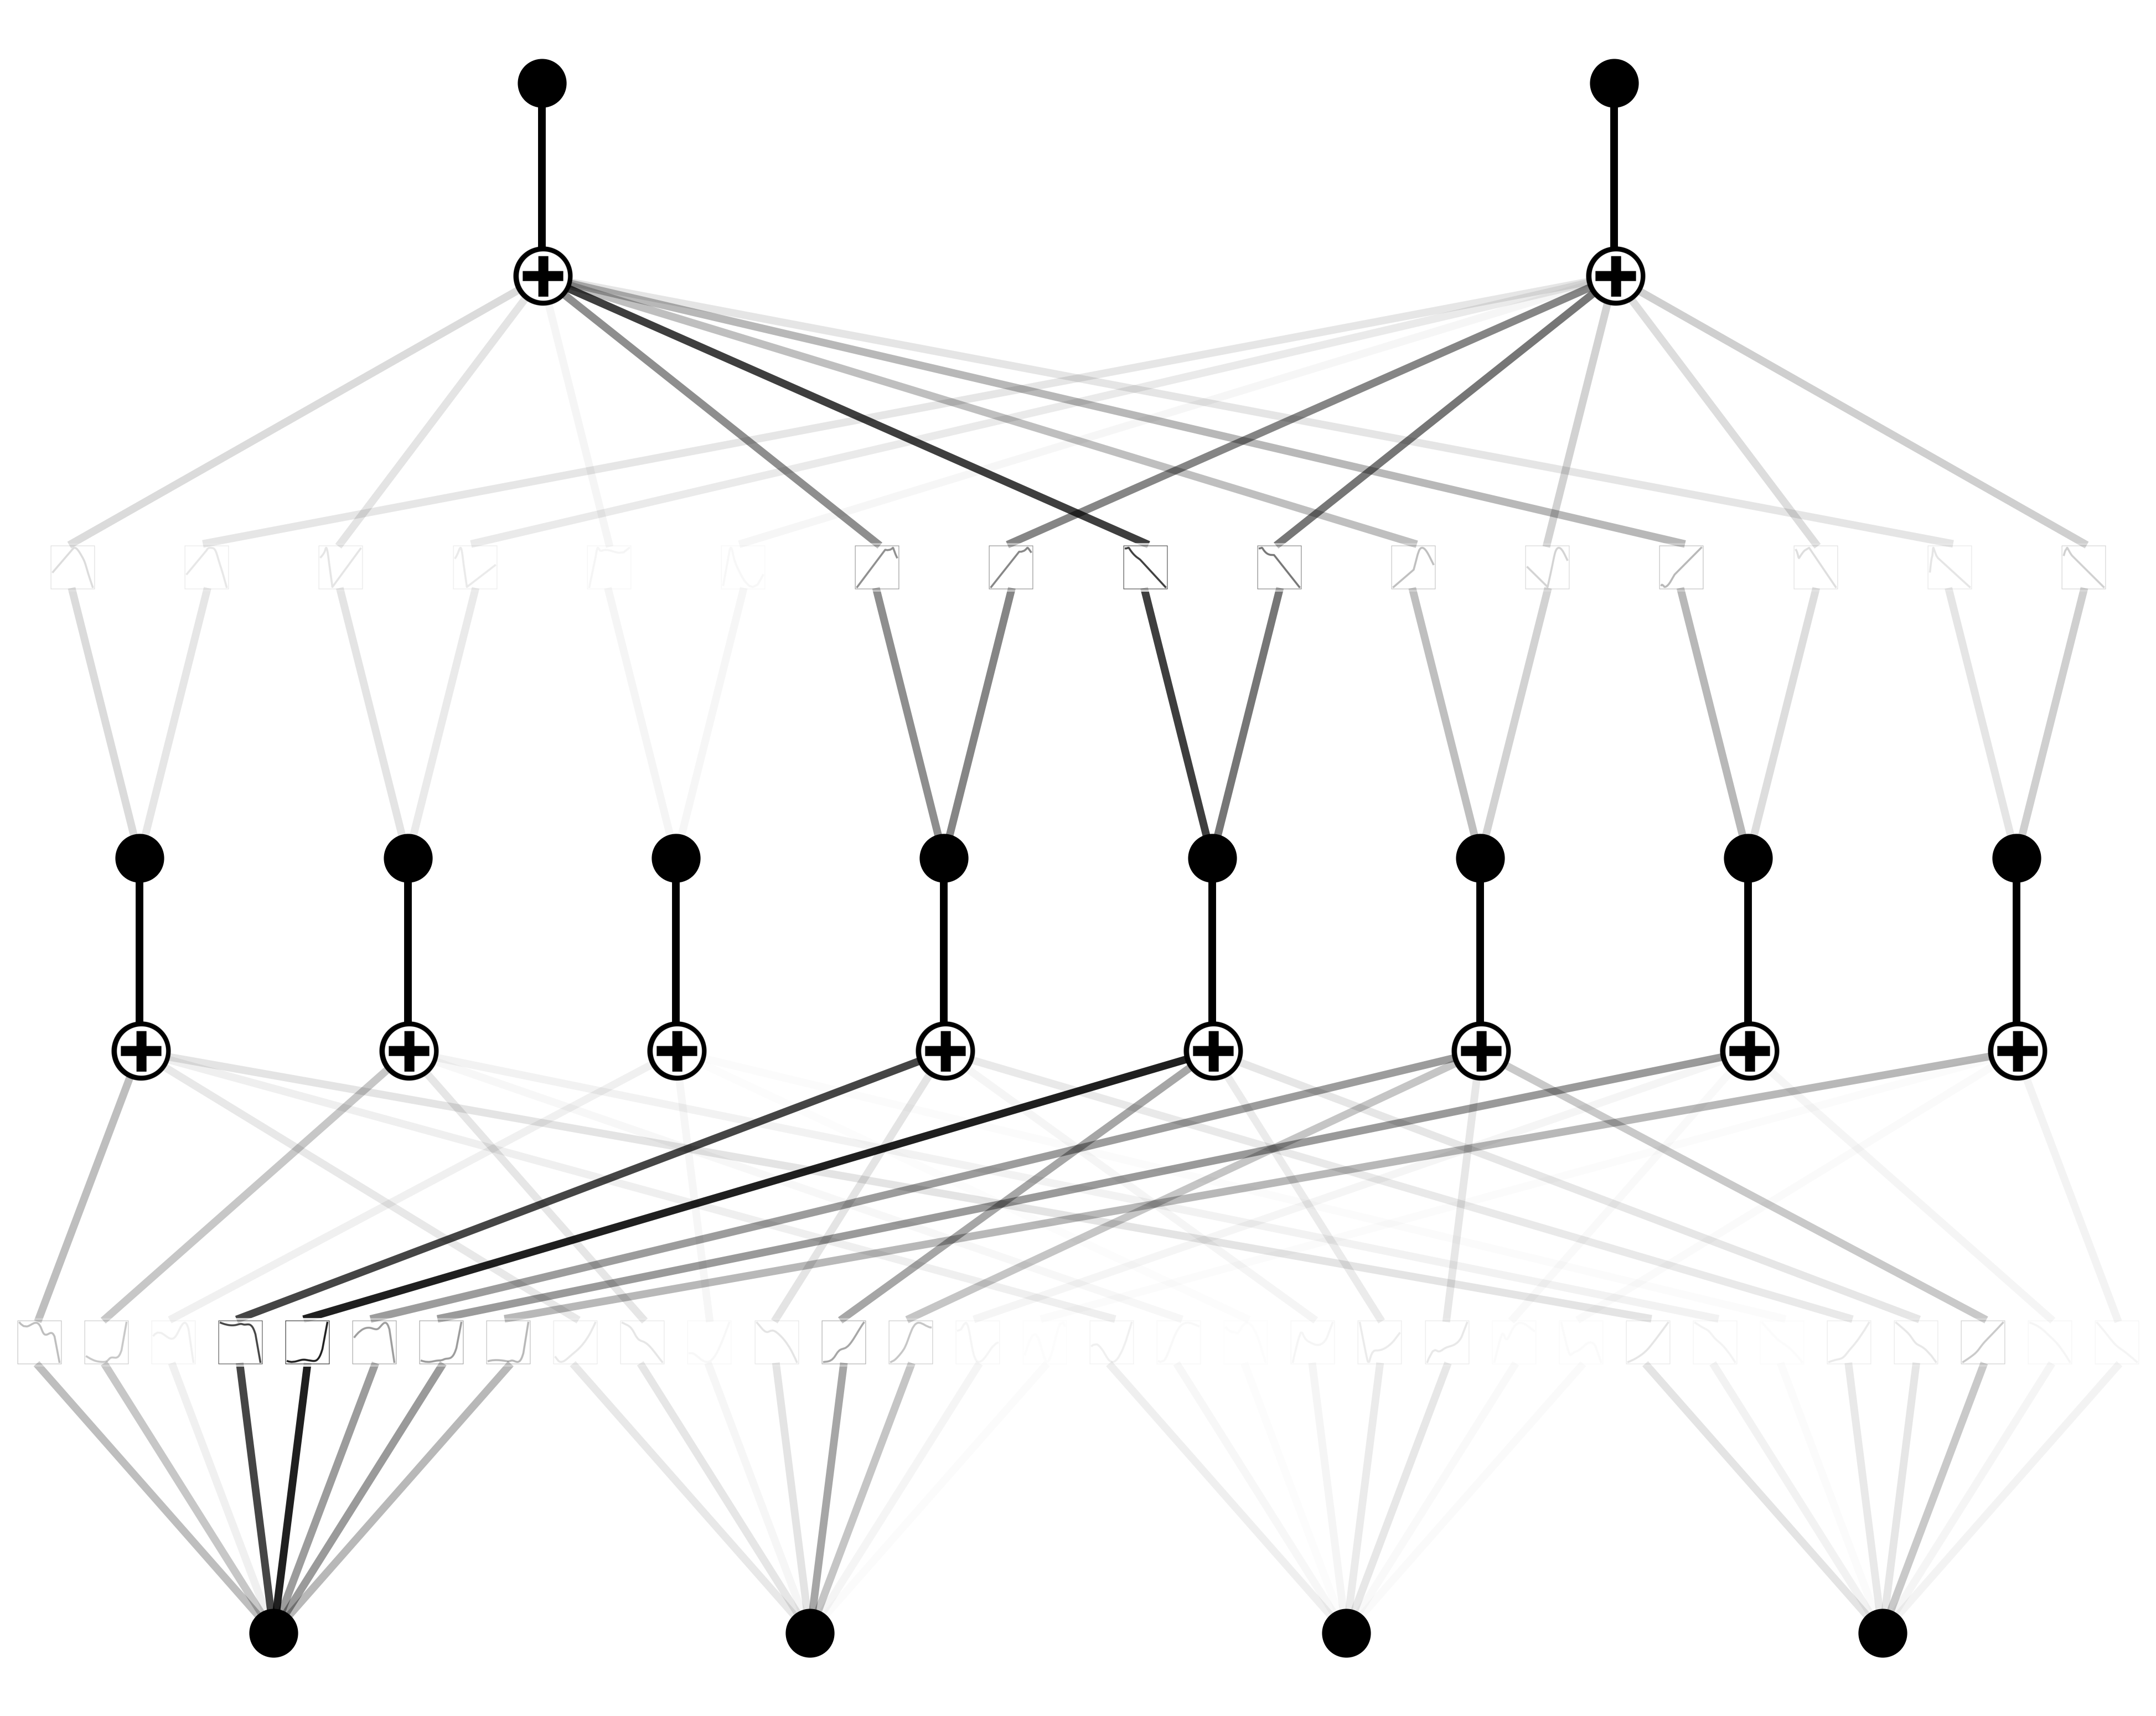

In [4]:
model.plot(scale = 5)

In [14]:
# plt.figure()
x_mlp = [i for i in range(1, len(loss_mlp[0])+1)]


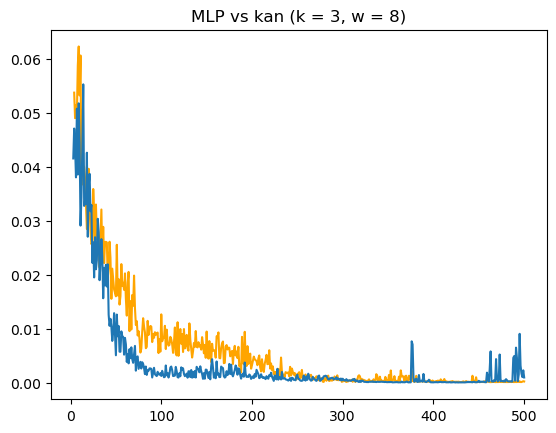

In [16]:
plt.plot(x_mlp, loss_mlp[0], color = 'orange')
plt.plot(x, loss)
plt.title(f'MLP vs kan (k = 3, w = 8)')
plt.show()